<a href="https://colab.research.google.com/github/7201krap/KNU_RA/blob/main/SARSA_vs_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
from collections import defaultdict 

In [16]:
EPSILON_START = 0.01
EPSILON_END   = 0
EPSILON_DECAY = 40000

gamma = 0.9     # discount factor
alpha = 0.1     # learning rate

# EPSILON = 0.1, gamma = 1 이면 SARSA는 빙 둘러서 가게 된다. (Reward 또한 -1인 경우)

In [17]:
import numpy as np
from collections import defaultdict

# define state
starting_pos = (3,0)
state = defaultdict(lambda : 0)

for i in range(4):
    for j in range(12):
        if i == 3 and j >= 1 and j < 11:
            state[(i,j)] = -1
        elif i == 3 and j == 11:
            state[(i,j)] = 1
        else:
            state[(i,j)] = 0

# define action 
actions = ["up", "down", "left", "right"]

In [18]:
# Visualise Current State Board

visualization = np.array(list(state.items()))

visualization = np.reshape(visualization, (4, 24))

BOARD = np.zeros((4, 12))

print("================== CURRENT BOARD ==================")
for i in range(4):
    for j in range(12):
        if visualization[i][2*j + 1] == 0:
            BOARD[i][j] = 0
        elif visualization[i][2*j + 1] == 1:
            BOARD[i][j] = 1
        else:
            BOARD[i][j] = -1

print(BOARD)

================== CURRENT BOARD ==================
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
def NextState(current_pos, action):
    origin = current_pos
    nxt_state_row = current_pos[0]
    nxt_state_col = current_pos[1]
    if action == 'up':
        nxt_state_row -= 1
    elif action == 'down':
        nxt_state_row += 1
    elif action == 'left':
        nxt_state_col -= 1
    elif action == 'right':
        nxt_state_col += 1
    if nxt_state_row >= 0 and nxt_state_row <= 3:
        if nxt_state_col >= 0 and nxt_state_col <= 11:
            return (nxt_state_row, nxt_state_col)
        else:
            return origin
    else:
        return origin

# reward function
def reward(pos):
    if state[pos] == -1:
        return -100
    elif state[pos] == 1:
        return 1
    else:
        return -1

In [20]:
Q_table_SARSA = defaultdict(lambda : 0)
pi_table_SARSA = defaultdict(lambda : 0)
Q_table_Q_learning = defaultdict(lambda : 0)
pi_table_Q_learning = defaultdict(lambda : 0)

reward_sum_list_SARSA = []
reward_sum_list_Q_learning = []

In [21]:
# choose action on epsilon-greedy-policy
def ChooseAction(current_pos, Q_table, epsilon):
    if np.random.uniform(0,1) <= epsilon:
        return np.random.choice(actions)
    else:
        Q_up = Q_table[(current_pos,'up')]
        Q_down = Q_table[(current_pos,'down')]
        Q_left = Q_table[(current_pos,'left')]
        Q_right = Q_table[(current_pos,'right')]
        QList = [Q_up, Q_down, Q_left, Q_right]
        
        return actions[np.argmax(QList)] 

In [22]:
# SARSA control
def play_episode_SARSA(starting_pos, actions, epsil):
    episode = []
    rewardList_SARSA = []
    current_state = starting_pos
    while True:

        if state[current_state] == -1:
            episode.append(current_state)
            break

        action = ChooseAction(current_state, Q_table_SARSA, epsil)
        next_state = NextState(current_state, action)
        r = reward(next_state)

        rewardList_SARSA.append(r) # for making episode-reward graph
        episode.append([current_state, action, r])
        next_action = ChooseAction(next_state, Q_table_SARSA, epsil)

        Q_table_SARSA[current_state, action] = (1 - alpha) * Q_table_SARSA[current_state, action] + alpha * (r + gamma * Q_table_SARSA[next_state, next_action])

        current_state = next_state
        action = next_action

        if current_state == (3,11):
            episode.append(current_state)
            break

    reward_sum_list_SARSA.append(sum(rewardList_SARSA))

In [23]:
# Q-learning control
def play_episode_Qlearning(starting_pos, actions, epsil):
    episode = []
    rewardList_Q_learning = []
    current_state = starting_pos
    while True:

        if state[current_state] == -1:
            episode.append(current_state)
            break

        action = ChooseAction(current_state, Q_table_Q_learning, epsil)
        next_state = NextState(current_state, action)
        r = reward(next_state)

        rewardList_Q_learning.append(r) # for making episode-reward graph
        episode.append([current_state, action, r])
        optimal_action = ChooseAction(next_state, Q_table_Q_learning, 0)

        Q_table_Q_learning[current_state, action] = (1 - alpha) * Q_table_Q_learning[current_state, action] + alpha * (r + gamma*Q_table_Q_learning[next_state, optimal_action])

        current_state = next_state

        if current_state == (3,11):
            episode.append(current_state)
            break
    #print(episode)
    reward_sum_list_Q_learning.append(sum(rewardList_Q_learning))

In [24]:
# play episode on SARSA control
count = 50000

for i in range(count):

    epsilon = np.interp(i, [0, EPSILON_DECAY], [EPSILON_START, EPSILON_END])

    play_episode_SARSA(starting_pos, actions, epsilon)

In [25]:
# play episode on Q-learning control
for i in range(count):

    epsilon = np.interp(i, [0, EPSILON_DECAY], [EPSILON_START, EPSILON_END])

    play_episode_Qlearning(starting_pos, actions, epsilon)

In [26]:
# pi_table_SARSA update 
for i in range(4):
    for j in range(12):
        Q_up = Q_table_SARSA[((i,j),'up')]
        Q_down = Q_table_SARSA[((i,j),'down')]
        Q_left = Q_table_SARSA[((i,j),'left')]
        Q_right = Q_table_SARSA[((i,j),'right')]

        QList = [Q_up,Q_down,Q_left,Q_right]
        pi_table_SARSA[(i,j)] = actions[np.argmax(QList)] 


# pi_table_Qlearning update 
for i in range(4):
    for j in range(12):
        Q_up = Q_table_Q_learning[((i,j),'up')]
        Q_down = Q_table_Q_learning[((i,j),'down')]
        Q_left = Q_table_Q_learning[((i,j),'left')]
        Q_right = Q_table_Q_learning[((i,j),'right')]
        QList = [Q_up,Q_down,Q_left,Q_right]

        pi_table_Q_learning[(i,j)] = actions[np.argmax(QList)] 

In [27]:
# SARSA

for i in range(4):
    print('-------------------------------------------------------------')
    out = '| '
    for j in range(12):
        if pi_table_SARSA[(i,j)] == 'up':
            token = '↑'
        if pi_table_SARSA[(i,j)] == 'down':
            token = '↓'
        if pi_table_SARSA[(i,j)] == 'right':
            token = '→'
        if pi_table_SARSA[(i,j)] == 'left':
            token = '←'
        if state[(i,j)] == -1:
            token = '**'
        if (i, j) == (3,11):
            token = ' G'
        if (i, j) == (3, 0):
            token = 'S '
        out += token + ' | '
    print(out)
print('-------------------------------------------------------------')

-------------------------------------------------------------
| → | → | ↓ | → | → | → | → | → | → | → | → | ↓ | 
-------------------------------------------------------------
| → | → | → | → | → | → | → | → | → | → | → | ↓ | 
-------------------------------------------------------------
| ↑ | → | ↑ | ↑ | ↑ | → | → | ↑ | → | ↑ | → | ↓ | 
-------------------------------------------------------------
| S  | ** | ** | ** | ** | ** | ** | ** | ** | ** | ** |  G | 
-------------------------------------------------------------


In [28]:
# Q-Learning

for i in range(4):
    print('-------------------------------------------------------------')
    out = '| '
    for j in range(12):
        if pi_table_Q_learning[(i,j)] == 'up':
            token = '↑'
        if pi_table_Q_learning[(i,j)] == 'down':
            token = '↓'
        if pi_table_Q_learning[(i,j)] == 'right':
            token = '→'
        if pi_table_Q_learning[(i,j)] == 'left':
            token = '←'
        if state[(i,j)] == -1:
            token = '**'
        if (i, j) == (3,11):
            token = ' G'
        if (i, j) == (3, 0):
            token = 'S '
        out += token + ' | '
    print(out)
print('-------------------------------------------------------------')

-------------------------------------------------------------
| ↑ | ← | → | → | ← | → | → | → | → | → | → | ↓ | 
-------------------------------------------------------------
| → | → | ↑ | → | → | ↓ | → | ↓ | → | → | ↓ | ↓ | 
-------------------------------------------------------------
| → | → | → | → | → | → | → | → | → | → | → | ↓ | 
-------------------------------------------------------------
| S  | ** | ** | ** | ** | ** | ** | ** | ** | ** | ** |  G | 
-------------------------------------------------------------


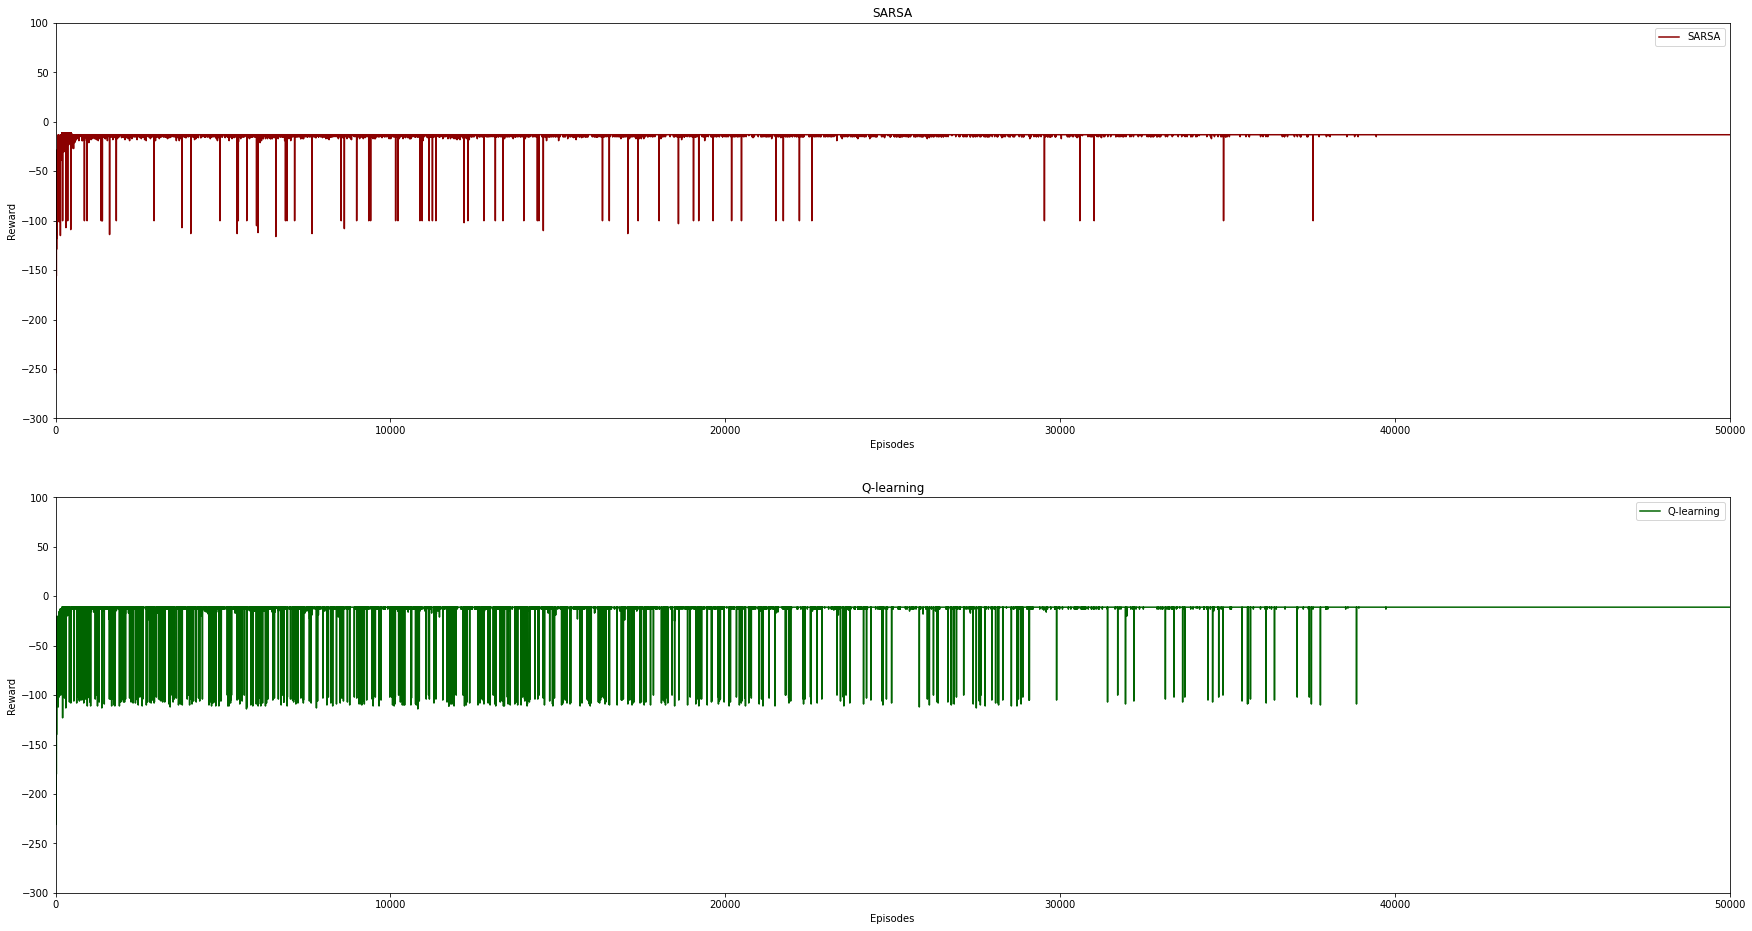

In [29]:
import matplotlib.pyplot as plt

episode_count = []

for i in range(count):
    episode_count.append(i+1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 16))

ax1.plot(episode_count,reward_sum_list_SARSA, c='darkred', label='SARSA')
ax1.set_title("SARSA")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Reward")
ax1.set_ylim([-300, 100])
ax1.set_xlim(0,50000)
ax1.legend()

ax2.plot(episode_count,reward_sum_list_Q_learning, c='darkgreen', label='Q-learning')
ax2.set_title("Q-learning")
ax2.set_xlabel("Episodes")
ax2.set_ylabel("Reward")
ax2.set_ylim([-300, 100])
ax2.set_xlim(0,50000)
ax2.legend()